In [1]:
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from src import *

TOTAL_SIMULATIONS = 1000
SEED = 42
SIMULATION_DIR = "simulations-data"
ESPECIF_SIMULATION_VIEW = 3

## 1. Generate Simulations

In [2]:
if os.path.exists(SIMULATION_DIR):
    print(f"'{SIMULATION_DIR}' already exists — skipping generation.")
else:
    os.makedirs(SIMULATION_DIR)
    random.seed(SEED)
    for i in range(TOTAL_SIMULATIONS):
        result = play_simulation('config/simulations', 'config/sessions', 'config/games', 'current')
        with open(os.path.join(SIMULATION_DIR, f'simulation_{i}.json'), 'w') as f:
            json.dump(result, f)
        if (i + 1) % 10000 == 0:
            print(f"Generated {i + 1}/{TOTAL_SIMULATIONS} simulations")
    print(f"Done — {TOTAL_SIMULATIONS} simulations saved to '{SIMULATION_DIR}'.")

Done — 1000 simulations saved to 'simulations-data'.


In [3]:
# Load all simulations into memory
START_BANKROLL = 1000  # from config/simulations/current.json

simulations = []
for i in range(TOTAL_SIMULATIONS):
    filepath = os.path.join(SIMULATION_DIR, f'simulation_{i}.json')
    with open(filepath, 'r') as f:
        simulations.append(json.load(f))

print(f"Loaded {len(simulations)} simulations.")

Loaded 1000 simulations.


## 2. Game Expected Values

In [4]:
all_evs = get_all_games_ev('config/games')

for game_name, ev_data in all_evs.items():
    print(f"--- {ev_data['name']} ---")
    if 'ev' in ev_data:
        print(f"  EV: {ev_data['ev']:+.6f}")
    elif 'bet-types' in ev_data:
        for bt, ev_val in ev_data['bet-types'].items():
            print(f"  {bt}: {ev_val:+.6f}")
    print()

--- Sit & Go 9 Players ---
  EV: -0.190000

--- Multi-Table Tournament ---
  EV: -0.030700

--- Baccarat ---
  player: -0.107600
  banker: -0.010530
  tie: -0.143200

--- Slots ---
  EV: +3.800000



## 3. Average Simulation Results

In [5]:
def extract_bankroll_history(sim):
    """Extract the full bankroll history (bet-by-bet) from a simulation."""
    history = [START_BANKROLL]
    for action in sim:
        if action['type'] == 'play':
            for bet in action['bets']:
                history.append(bet['bankroll'])
        else:
            history.append(action['bankroll'])
    return history

final_bankrolls = []
min_bankrolls = []
max_bankrolls = []
total_bets_list = []
profits = []
bankroll_histories = []

for sim in simulations:
    history = extract_bankroll_history(sim)
    bankroll_histories.append(history)
    final = history[-1]
    final_bankrolls.append(final)
    min_bankrolls.append(min(history))
    max_bankrolls.append(max(history))
    profit = final - START_BANKROLL
    profits.append(profit)
    total_bets = sum(len(a['bets']) for a in sim if a['type'] == 'play')
    total_bets_list.append(total_bets)

final_bankrolls = np.array(final_bankrolls)
profits = np.array(profits)
min_bankrolls = np.array(min_bankrolls)
max_bankrolls = np.array(max_bankrolls)
total_bets_list = np.array(total_bets_list)

destroyed = np.sum(final_bankrolls <= 0)
profitable = np.sum(profits > 0)
losing = np.sum(profits < 0)
breakeven = np.sum(profits == 0)

print("=" * 55)
print("       SIMULATION RESULTS SUMMARY")
print("=" * 55)
print(f"Total simulations:       {TOTAL_SIMULATIONS:>12,}")
print(f"Starting bankroll:       {START_BANKROLL:>12,.2f}")
print(f"")
print(f"--- Outcomes ---")
print(f"Bank destroyed (<=0):    {destroyed:>12,} ({destroyed/TOTAL_SIMULATIONS*100:.2f}%)")
print(f"Profitable sims:         {profitable:>12,} ({profitable/TOTAL_SIMULATIONS*100:.2f}%)")
print(f"Losing sims:             {losing:>12,} ({losing/TOTAL_SIMULATIONS*100:.2f}%)")
print(f"Break-even sims:         {breakeven:>12,} ({breakeven/TOTAL_SIMULATIONS*100:.2f}%)")
print(f"")
print(f"--- Profit / Loss ---")
print(f"Average profit:          {np.mean(profits):>12,.2f}")
print(f"Median profit:           {np.median(profits):>12,.2f}")
print(f"Std dev of profit:       {np.std(profits):>12,.2f}")
print(f"Average loss (losers):   {np.mean(profits[profits < 0]):>12,.2f}")
print(f"Average gain (winners):  {np.mean(profits[profits > 0]):>12,.2f}")
print(f"")
print(f"--- Bankroll ---")
print(f"Average final bankroll:  {np.mean(final_bankrolls):>12,.2f}")
print(f"Median final bankroll:   {np.median(final_bankrolls):>12,.2f}")
print(f"Min final bankroll:      {np.min(final_bankrolls):>12,.2f}")
print(f"Max final bankroll:      {np.max(final_bankrolls):>12,.2f}")
print(f"Global min bankroll:     {np.min(min_bankrolls):>12,.2f}")
print(f"Global max bankroll:     {np.max(max_bankrolls):>12,.2f}")
print(f"")
print(f"--- Bets ---")
print(f"Average total bets:      {np.mean(total_bets_list):>12,.1f}")
print(f"Min total bets:          {np.min(total_bets_list):>12,}")
print(f"Max total bets:          {np.max(total_bets_list):>12,}")
print("=" * 55)

       SIMULATION RESULTS SUMMARY
Total simulations:              1,000
Starting bankroll:           1,000.00

--- Outcomes ---
Bank destroyed (<=0):               0 (0.00%)
Profitable sims:                  463 (46.30%)
Losing sims:                      535 (53.50%)
Break-even sims:                    2 (0.20%)

--- Profit / Loss ---
Average profit:                 -3.47
Median profit:                  -3.62
Std dev of profit:              45.70
Average loss (losers):         -37.24
Average gain (winners):         35.53

--- Bankroll ---
Average final bankroll:        996.53
Median final bankroll:         996.38
Min final bankroll:            826.50
Max final bankroll:          1,149.50
Global min bankroll:           826.50
Global max bankroll:         1,159.75

--- Bets ---
Average total bets:              99.3
Min total bets:                    63
Max total bets:                   136


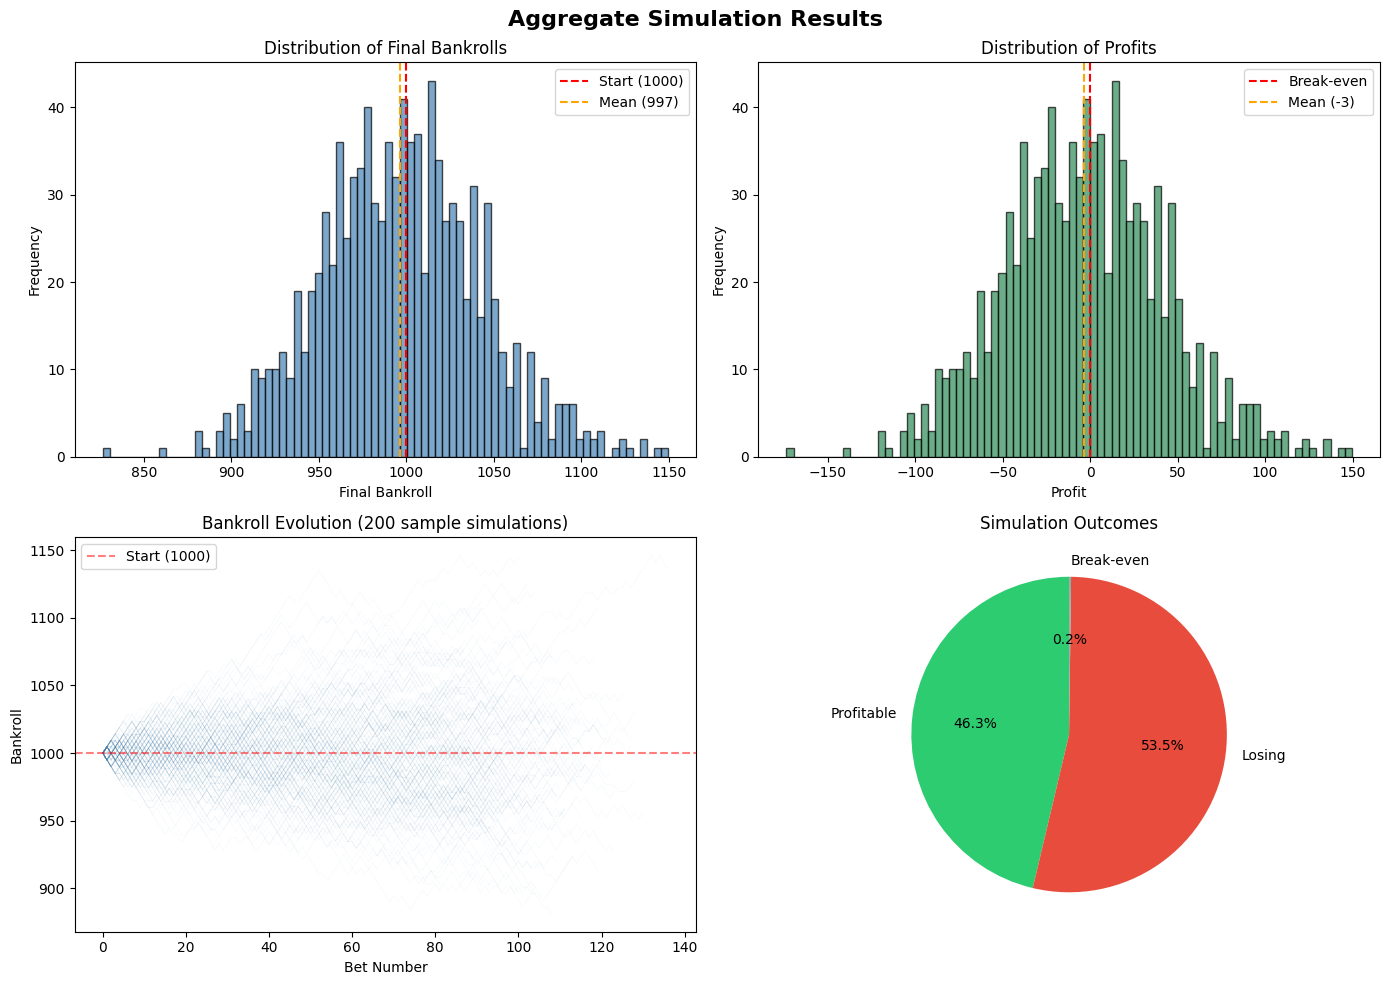

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Aggregate Simulation Results', fontsize=16, fontweight='bold')

# 1 - Distribution of final bankrolls
ax = axes[0, 0]
ax.hist(final_bankrolls, bins=80, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(START_BANKROLL, color='red', linestyle='--', label=f'Start ({START_BANKROLL})')
ax.axvline(np.mean(final_bankrolls), color='orange', linestyle='--', label=f'Mean ({np.mean(final_bankrolls):.0f})')
ax.set_title('Distribution of Final Bankrolls')
ax.set_xlabel('Final Bankroll')
ax.set_ylabel('Frequency')
ax.legend()

# 2 - Distribution of profits
ax = axes[0, 1]
ax.hist(profits, bins=80, color='seagreen', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='Break-even')
ax.axvline(np.mean(profits), color='orange', linestyle='--', label=f'Mean ({np.mean(profits):.0f})')
ax.set_title('Distribution of Profits')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
ax.legend()

# 3 - Bankroll evolution (sample of 200 simulations)
ax = axes[1, 0]
sample_indices = np.linspace(0, TOTAL_SIMULATIONS - 1, 200, dtype=int)
for idx in sample_indices:
    h = bankroll_histories[idx]
    ax.plot(range(len(h)), h, alpha=0.05, color='steelblue', linewidth=0.5)
ax.axhline(START_BANKROLL, color='red', linestyle='--', alpha=0.5, label=f'Start ({START_BANKROLL})')
ax.set_title('Bankroll Evolution (200 sample simulations)')
ax.set_xlabel('Bet Number')
ax.set_ylabel('Bankroll')
ax.legend()

# 4 - Win rate pie chart
ax = axes[1, 1]
labels = ['Profitable', 'Losing', 'Break-even']
sizes = [profitable, losing, breakeven]
colors_pie = ['#2ecc71', '#e74c3c', '#95a5a6']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax.set_title('Simulation Outcomes')

plt.tight_layout()
plt.show()

## 4. Best, Worst and Average Simulations

In [7]:
idx_worst = int(np.argmin(final_bankrolls))
idx_best = int(np.argmax(final_bankrolls))

# "Average" simulation: the one whose final bankroll is closest to the mean
mean_final = np.mean(final_bankrolls)
idx_avg = int(np.argmin(np.abs(final_bankrolls - mean_final)))

highlight = {
    'Most Lost': (idx_worst, '#e74c3c'),
    'Most Profitable': (idx_best, '#2ecc71'),
    'Average': (idx_avg, '#3498db'),
}

for label, (idx, _) in highlight.items():
    h = bankroll_histories[idx]
    print(f"{label} (sim #{idx}): start={START_BANKROLL}  final={h[-1]:.2f}  "
          f"min={min(h):.2f}  max={max(h):.2f}  bets={len(h)-1}")

Most Lost (sim #477): start=1000  final=826.50  min=826.50  max=1004.50  bets=109
Most Profitable (sim #408): start=1000  final=1149.50  min=999.00  max=1159.75  bets=97
Average (sim #355): start=1000  final=996.50  min=933.75  max=1001.50  bets=120


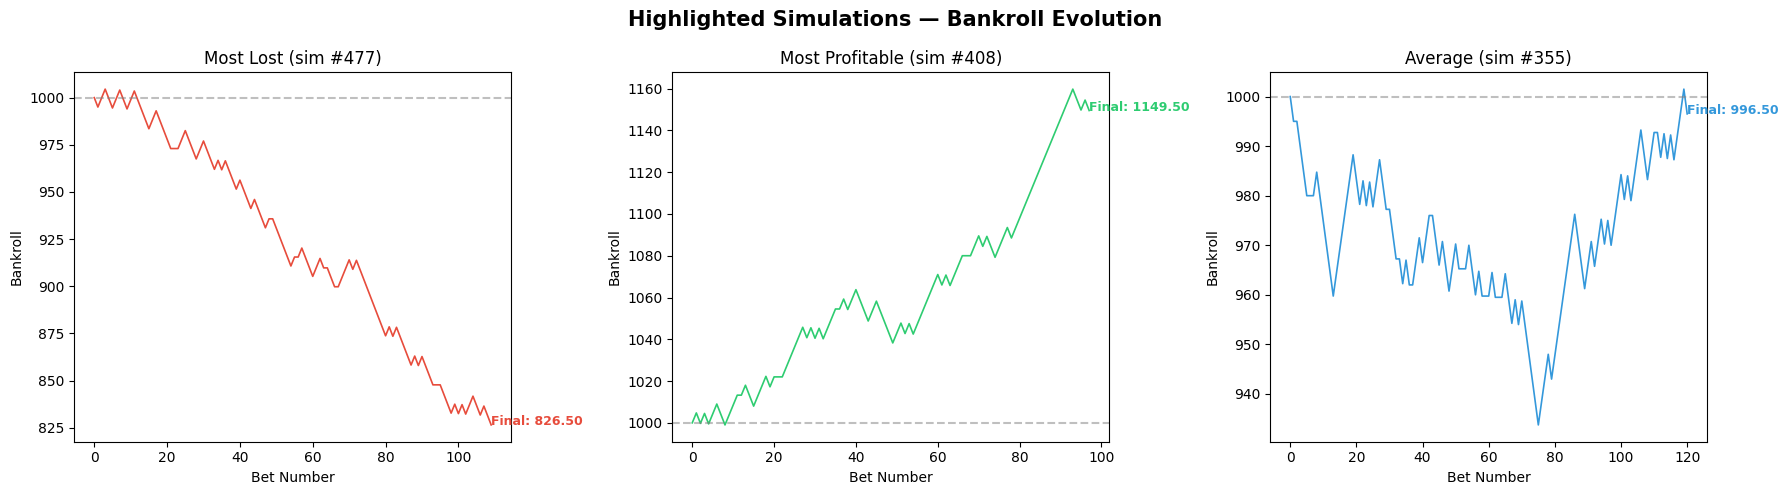

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Highlighted Simulations — Bankroll Evolution', fontsize=15, fontweight='bold')

for ax, (label, (idx, color)) in zip(axes, highlight.items()):
    h = bankroll_histories[idx]
    ax.plot(range(len(h)), h, color=color, linewidth=1.2)
    ax.axhline(START_BANKROLL, color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f'{label} (sim #{idx})')
    ax.set_xlabel('Bet Number')
    ax.set_ylabel('Bankroll')
    ax.annotate(f'Final: {h[-1]:.2f}', xy=(len(h)-1, h[-1]),
                fontsize=9, fontweight='bold', color=color)

plt.tight_layout()
plt.show()

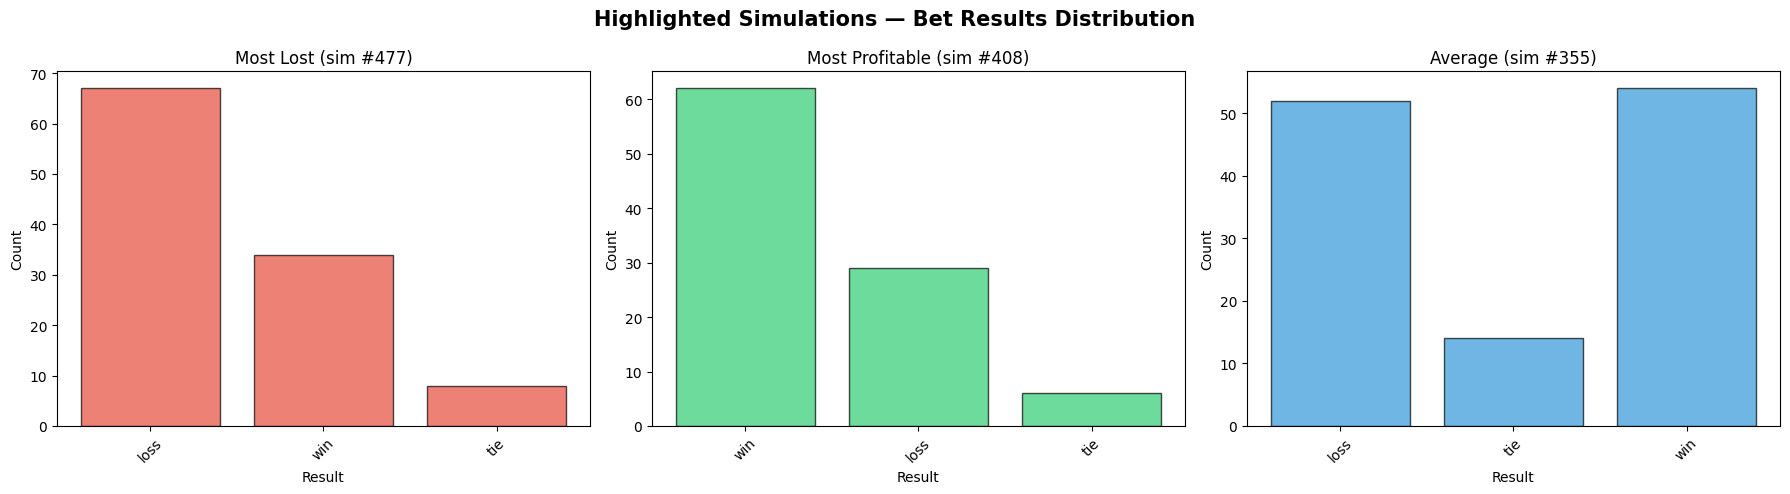

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Highlighted Simulations — Bet Results Distribution', fontsize=15, fontweight='bold')

for ax, (label, (idx, color)) in zip(axes, highlight.items()):
    sim = simulations[idx]
    results_list = []
    for action in sim:
        if action['type'] == 'play':
            for bet in action['bets']:
                results_list.append(bet['result'])
    from collections import Counter
    counts = Counter(results_list)
    labels_bar = list(counts.keys())
    values_bar = list(counts.values())
    ax.bar(labels_bar, values_bar, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{label} (sim #{idx})')
    ax.set_xlabel('Result')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Specific Simulation View

       SIMULATION #3 — DETAILED VIEW
Starting bankroll: 1000
Final bankroll:    1038.00
Profit:            +38.00
Min bankroll:      994.00
Max bankroll:      1053.00

--- Action 1: PLAY ---
  Session: Avarage Baccarat
  Bets played: 22
    Bet 1: Baccarat (banker)  size=5.00  result=win  net=+4.75  bankroll=1004.75
    Bet 2: Baccarat (banker)  size=5.00  result=loss  net=-5.00  bankroll=999.75
    Bet 3: Baccarat (banker)  size=5.00  result=win  net=+4.75  bankroll=1004.50
    Bet 4: Baccarat (banker)  size=5.00  result=loss  net=-5.00  bankroll=999.50
    Bet 5: Baccarat (banker)  size=5.00  result=loss  net=-5.00  bankroll=994.50
    Bet 6: Baccarat (banker)  size=5.00  result=win  net=+4.75  bankroll=999.25
    Bet 7: Baccarat (banker)  size=5.00  result=loss  net=-5.00  bankroll=994.25
    Bet 8: Baccarat (banker)  size=5.00  result=tie  net=+0.00  bankroll=994.25
    Bet 9: Baccarat (banker)  size=5.00  result=win  net=+4.75  bankroll=999.00
    Bet 10: Baccarat (banker)  size=5

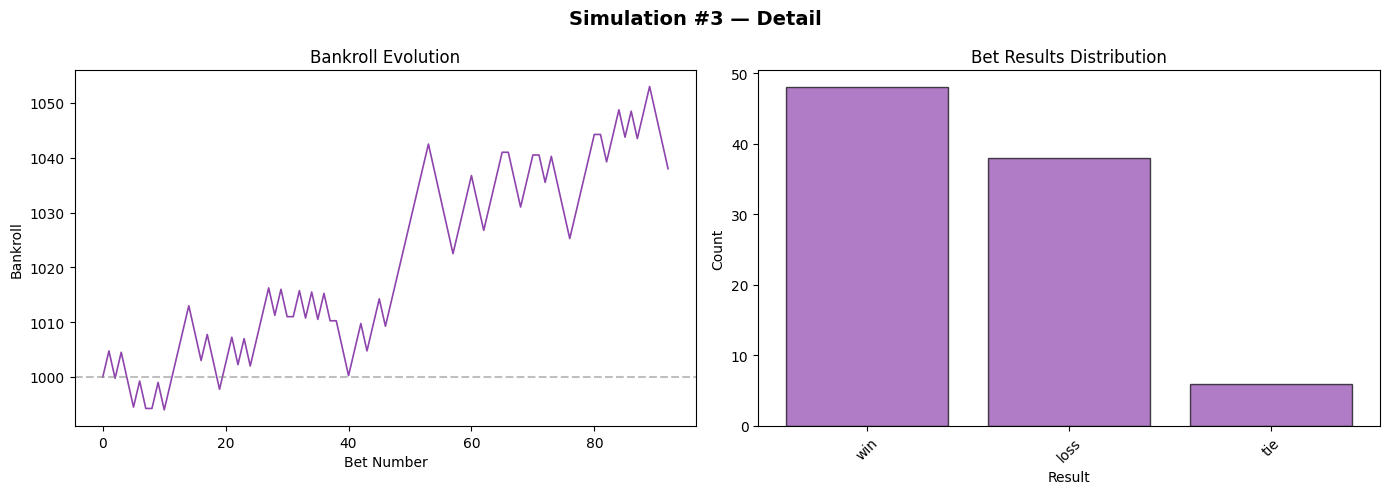

In [10]:
if ESPECIF_SIMULATION_VIEW is not None:
    idx = ESPECIF_SIMULATION_VIEW
    sim = simulations[idx]
    history = bankroll_histories[idx]

    print("=" * 55)
    print(f"       SIMULATION #{idx} — DETAILED VIEW")
    print("=" * 55)
    print(f"Starting bankroll: {START_BANKROLL}")
    print(f"Final bankroll:    {history[-1]:.2f}")
    print(f"Profit:            {history[-1] - START_BANKROLL:+.2f}")
    print(f"Min bankroll:      {min(history):.2f}")
    print(f"Max bankroll:      {max(history):.2f}")
    print()

    bet_counter = 0
    for i, action in enumerate(sim):
        print(f"--- Action {i+1}: {action['type'].upper()} ---")
        if action['type'] == 'play':
            print(f"  Session: {action['name']}")
            print(f"  Bets played: {len(action['bets'])}")
            for bet in action['bets']:
                bet_counter += 1
                net = bet['payment'] - bet['bet-size']
                print(f"    Bet {bet_counter}: {bet['game']}"
                      f"{' (' + bet['bet-type'] + ')' if bet.get('bet-type') else ''}"
                      f"  size={bet['bet-size']:.2f}  result={bet['result']}"
                      f"  net={net:+.2f}  bankroll={bet['bankroll']:.2f}")
        elif action['type'] == 'withdraw':
            print(f"  Withdrawn: {action['size']:.2f}  bankroll={action['bankroll']:.2f}")
        elif action['type'] == 'aport':
            print(f"  Deposited: {action['size']:.2f}  bankroll={action['bankroll']:.2f}")
        print()

    # Plot this specific simulation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Simulation #{idx} — Detail', fontsize=14, fontweight='bold')

    axes[0].plot(range(len(history)), history, color='#8e44ad', linewidth=1.2)
    axes[0].axhline(START_BANKROLL, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title('Bankroll Evolution')
    axes[0].set_xlabel('Bet Number')
    axes[0].set_ylabel('Bankroll')

    results_list = []
    for action in sim:
        if action['type'] == 'play':
            for bet in action['bets']:
                results_list.append(bet['result'])
    from collections import Counter
    counts = Counter(results_list)
    axes[1].bar(counts.keys(), counts.values(), color='#8e44ad', edgecolor='black', alpha=0.7)
    axes[1].set_title('Bet Results Distribution')
    axes[1].set_xlabel('Result')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()